# Apprentissage ensembliste et Forêts Aléatoires

Comme exemple d'EM, on peut entraîner un groupe de classificateurs DT, chacun sur un sous-ensemble aléatoire différent du JdE. Pour faire des prédictions, on prend les prédictions de chaque arbre, et on prédit la classe qui obtient le plus de vote. Cet ensemble de DT est appelé une RF, et en dépit de sa simplicité, c'est un des plus puissants algo de ML disponible aujourd'hui.

## Setup

In [2]:
#python >= 3.5 nécessaire
import sys
assert sys.version_info >= (3, 5)

#scikit-learn >= 0.20 nécessaire
import sklearn
assert sklearn.__version__ >= "0.20"

# Autres imports
import numpy as np
import os

# pour rendre les output stables au fil des runs
np.random.seed(42)

# pour tracer de jolis graphes
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# où sauvegarder les figures
PROJECT_ROOT_DIR = ".."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Classificateurs de vote

Supposons qu'on a entraîné quelques que classificateurs, chacun atteignant 80% de précision. On peut avoir un classificateur de Régression Logistique, SVM, RF, KNN voire même quelques autres de plus.

![](fig1.png)

Une manière très simple de créer un meilleur classificateur est d'agréger les prédictions de chaque classificateur et de prédire la classe qui obtient le plus de votes. Ce vote classificateur de vote par majorité est appelé un classificateur *hard voting*.

![](fig2.png)

Quelque peu surprenant, ce classificateur de vote atteint souvent des précisions plis haute que le meilleur des classificateurs de l'ensemble. En fait, même si chaque classificateur est un apprenant faible (*weak learner*, il fait ne fait qu'un peu mieux qu'une supposition aléatoire), l'ensemble peu être un apprenant fort (*strong learner*, qui atteint une haute précision), à condition qu'ils soient en nombre suffisant et qu'ils soient assez diversifiés.

Comment est-ce possible ? L'analogie suivante peut aider à faire la muière sur ce mystère. Imaginons qu'on a une pièce légèrement biaisée qui a 51% de chance de faire face et 49% de chance de faire pile. Si on la jette mille fois, on devrait générallement obtenir plus ou moins 510 faces et 490 piles, et par conséquent, une majorité de faces. Si on fait le calcul, on trouvera que la probabilité d'obtenir une majorité de faces après 1000 essais est proche de 75%. Plus on effectue de lancers, plus la probabilité monte (97% à 10000). Ceci est dû à *loi des grands nombres* : tant qu'on continue à faire des lancers, le ration de faces devient de plus en plus proche de la probabilité de tirer face ($51%$).

La figure ci-dessous montre 10 séries de jeters de pièces biaisées. On peut voir qu'à mesure que le nombre de lancers augmente, le ratio "face" approche $51%$. À la fin, les 10 séries finissent si proches des $51%$ qu'elles sont au dessus de 50%.

In [3]:
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

Saving figure law_of_large_numbers_plot


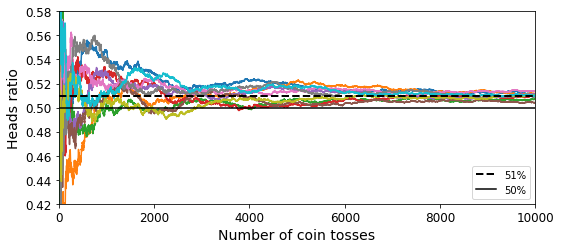

In [5]:
plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
save_fig("law_of_large_numbers_plot")
plt.show()

De manière similaire, supposons qu'on veuille construire un ensemble contenant 1000 classificateurs qui sont individuellement corrects 51% du temps (légèrement mieux qu'une supposition aléatoire). Si on prédit la classe votée majoritairement, on peut espérer atteindre 75% de précision.

Cependant, ceci est vrai seulement si tous les classificateurs sont parfaitement indépendants, faisant des erreurs non-correlées, ce qui n'est clairement pas le cas parce qu'ils sont entraînés sur les mêmes données. Ils auront tendance à faire les mêmes types d'erreurs, donc il y aura beaucoup de vote par majorité pour la mauvaise classe, réduisant la précision de l'ensemble.

*Remarque* : Les EM fonctionnent mieux quand les prédicteurs sont aussi indépendants les uns des autres que possible. Une manière d'avoir des classificateurs divers est de les entraîner en utilisant des algo très différents. Cela augmente les chances qu'ils feront des types d'erreurs très différents, améliorant la précision de l'ensemble.

Le code suivant crée et entraîne un classificateur de vote dans sklearn, cposé de trois classficiateurs différents (le JdE est le moons dataset) :


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Pour stabiliser le notebook à l'avenir, on va fixer `solver=lbfgs`, `n_estimators=100` et `gamma=scale`

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(
    estimators=[("lr", log_clf), ("rf", rnd_clf), ("svc", svm_clf)],
    voting="hard"
)

In [9]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

Regardons la précision de chaque estimateurs sur le JdT :

In [10]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


On peut voir que le `VotingClassifier` a une performance légèrement meilleure que les autres.

Si tous les classificateurs sont capables d'estimer des probabilités de classe (cad, s'ils ont tous une méthode `predict_proba()`), alors on peut demander à sklearn de prédire la classe avec la plus haute probabilité de classe, moyenné sur tous les classificateurs individuels. C'est ce qu'on appelle le vote doux (*soft voting*).

Le vote doux atteint souvent de meilleures performances que le vote dur, parce qu'il donne plus de poids aux votes avec une haute confiance. Tout ce qu'on a besoin de faire est de remplacer `voting="hard"` par `voting="soft"` et de s'assurer que tous les classificateurs peuvent estimer des probabilité de classe.

Ceci n'est pas le cas pour la classe `SVC` par défaut, donc on a besoin de régler son hyperparamètre `probability` à `True` (cela va faire que la classe `SVC` va utiliser la validation croisée pour estimer les probabilités de classe, ralentissant l'entraînement, et ça ajoutera une méthode `predict_proba()`). Si on modifier le code précédent pour utiliser le vote doux, on trouvera que le classificateur dépasse les 91.2% de précision.

In [12]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [13]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


## *Bagging* et *Pasting*

Un moyen d'avoir un ensemble de classificateurs diversifié est d'utiliser des algo d'entraînement très diversifiés.

Une autre approche est d'utiliser le même algo d'entraînement pour chaque prédicteur et de les entraînement sur différents sous-ensembles du JdE.

Quand l'échantillonnage est réalisé *avec remplacement*, cette méthode est appelé *bagging* (pour *bootstrap aggregating*).

Quand l'échantillonnage est réalisé *sans remplacement*, cette méthode est appelée *pasting*.

En d'autres termes, le bagging et le pasting permettent d'échantillonner plusieurs instances d'entraînement
plusieurs fois sur plusieurs prédicteurs, mais seul le bagging permet aux instances d'entraînement d'être échantilloné plusieurs fois pour le même prédicteur. Cet échantillonnage et ce processus d'entraînement est représenté sur la figure ci-dessous :

![Le bagging et le pasting implique l'entraînement de nombreux prédicteurs sur différents échantillons aléatoires du jeu d'entraînement](fig4.png)

Une fois que tous les prédicteurs sont entraînés, l'ensemble peu faire des prédictions pour un nouvelle instance par simple aggrégation des prédictions de tous les prédicteurs. La fonction d'agrégation est typiquement le *mode statistique* (cad la plus fréquente prédiction, comme pour un classificateur vote dur), ou la moyenne de la régression. Chaque prédicateur a individuellement un plus ahute bias que s'il était entrapiné sur le JdE originel, mais l'agrégation réduit à la fois le biais et la variance. En génréal, le résultat net est que l'ensemble a un biais similaire mais une variance plus bas qu'un simple prédicteur entraîné sur le JdE originel.

Comme on peut le voir sur la dernière figure, les prédicteurs peuvent tous être entraînés en parallèle, via les différents cœurs du CPU ou même différents serveurs. Les prédictions peuvent également être faites en parallèle. C'est l'une des raisons pour laquelle le bagging et le plasting sont des méthodes aussi populaires : elle s'adaptent très bien. 

### Bagging et Pasting dans sklearn

sklearn fournit une API simple aussi bien pour le bagging que pour la psting, avec la classe `BaggingClassifier` (ou `BaggingRegressor` pour la régression). Le code suivant entraîne un ensemble de 500 classificateurs DT :

In [14]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42
)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [15]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [16]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


*Remarque* : le `BaggingClassifier` réalise automatique un vote doux plutôt qu'un dur si le classificateur de base peut estimer la probablité de classe (cad s'il a une méthode `predict_proba()`), ce qui est le cas avec les classificateurs des DT.

La figure suivante compare les limites de décision d'un simple DT avec la limite de décision d'un ensemble bagging de 500 arbres (du code précedent), les deux entraînés sur le moons dataset.

In [17]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

Saving figure decision_tree_without_and_with_bagging_plot


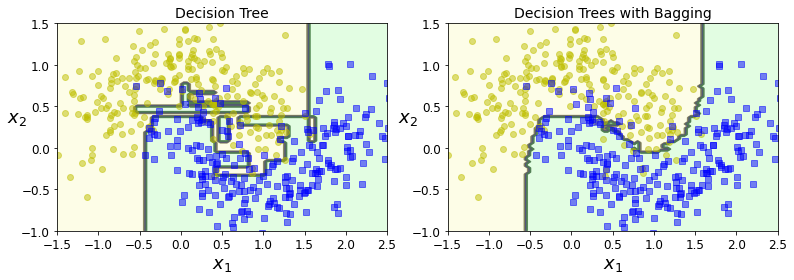

In [18]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

Comme on peut le voir, les prédictions de l'ensemble vont beaucoup mieux généraliser que le simple DT : l'ensemble a un biais comparable mais une variance plus petite (elle fait à peu près le même nombre d'erreurs sur le JdE, mais la limite de décision est moins irrégulière).

Le bootstrapping introduit un peu plus de diversité dans les sous-ensembles sur lesquels chaque prédicteur est formé, donc le bagging fini avec un biais légèrement plus haut que le pasting; mais la diversité supplémentaire veut également dire que les prédciteurs finiront par être moins corrélés, donc la vbariance de l'ensemble est réduite. 

Globalement, le bagging résulte souvent en de meilleurs modèles, ce qui explique pourquoi il est plus généralement préféré. Cependant, si on a du temps et un CPU puissant, on peut utiliser la validation croisée pour évaluer à la fois le bagging et le pasting, et sélectionner celui qui fonctionne le mieux.

### Évalutation out-of-bag

Avec le bagging, certaines instances peuvent être échantillonnées plusieurs fois pour n'importe quel prédicteur donné, alors que d'autres ne seront pas échantillonnées du tout. Par défaut, `BaggingClassifier` échantillonne $m$ instances d'entraînement avec remplacement (`bootstrap=True`), où $m$ est la taille du JdE. Cela veut dire que seulement 63% des instances d'entraînement sont échantillonnées en moyenne pour chaque prédicteur. Les 37% restantes ne sont pas échantillonnées et sont appelées des instances *out-of-bag* (*oob*). À noter qu'elles ne sont pas le même 37% pour chaque prédicteur.

Puisqu'un prédicteur ne voit jamais les instances oob pendant son entraînement, il peut être évalué sur ces instances, sans avoir besoin d'un JdV séparé. On peut évaluer l'ensemble lui-même en faisant la moyenne des évaluations oob de chaque prédicteur.

Dans sklearn, on peut définir `oob_score=True` quand on crée un `BaggingClassifier` pour demander une évalution oob automatique après l'entraînement. Le code suivant démontre cela. Le score d'évalutation résultant est disponibe au travers de la variable `oob_score_` :

In [20]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42),
    n_estimators=500,
    bootstrap=True,
    oob_score=True,
    random_state=40
)

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8986666666666666

D'après cette observation oob, ce `BaggingClassifier` est susceptible d'atteindre 89.9% de précision sur le JdT ; vérifions :

In [23]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

On obtient 91.2% de précision sur le JdT.

La fonction de décision oob pour chaque instance d'entraînement est également disponible via la variable `oob_decision_function_`. Dans ce cas (puisque l'estimateur de base a une méthode `predict_proba`), la fonction de décision retourne les probabilité de classe pour chaque instance d'entraînement. Par exemple, l'évaluation oob estime que la première instance d'entraînement a 67.7% de chance d'appartenir à la classe positive (et 32.3% de chance d'appartenir à la classe négative).

In [24]:
bag_clf.oob_decision_function_

array([[0.32275132, 0.67724868],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.09497207, 0.90502793],
       [0.31147541, 0.68852459],
       [0.01754386, 0.98245614],
       [0.97109827, 0.02890173],
       [0.97765363, 0.02234637],
       [0.74404762, 0.25595238],
       [0.        , 1.        ],
       [0.7173913 , 0.2826087 ],
       [0.85026738, 0.14973262],
       [0.97222222, 0.02777778],
       [0.0625    , 0.9375    ],
       [0.        , 1.        ],
       [0.97837838, 0.02162162],
       [0.94642857, 0.05357143],
       [1.        , 0.        ],
       [0.01704545, 0.98295455],
       [0.39473684, 0.60526316],
       [0.88700565, 0.11299435],
       [1.        , 0.        ],
       [0.97790055, 0.02209945],
       [0.        , 1.        ],
       [0.99428571, 0.00571429],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.62569832, 0.37430168],
       [0.

## Patches Aléatoires et Sous-Espaces Aléatoires (*Random Patches and Random Subspaces*)

La classe `BaggingClassifier` supporte aussi l'échantillonnage des features. L'échantillonnage (*sampling*) est contrôlé par deux hyperparamètres : `max_features` et `bootstratp_features`. Ils fonctionnent de la même manière que `max_samples` et `bootstrap`, mais pour des features plutôt que pour l'échnatillonnage d'instances. Ainsi, chaque prédicteur sera entraîné sur un sous-ensemble aléatoire des features d'entrée.

Cette technique est particulièrement utile quand on à affaire à des entrées de grande dimensions (comme les images). Échantillonner à la fois les instances d'entraînement et les features est appelé *méthode des patches aléatoires* (*[Random patches](https://www.semanticscholar.org/paper/Ensembles-on-Random-Patches-Louppe-Geurts/f5ae0b1b48a21ae9083f670d7043495f067064e4?p2df)*. Garder toutes les instances d'entraînement (en règlant `bootstrap=False` et `max_samples=1.0`) mais échantillonner les features (`bootstrap_features=True` et/ou `max_features` $<1$) est appelé *méthode des sous-espaces aléatoires* '(*[Random subspaces](https://www.researchgate.net/publication/3192880_The_Random_Subspace_Method_for_Constructing_Decision_Forests))*).

Échantilloner les features résulte en encore plus de diversité des prédicteurs, échangeant un peu plus de biais pour une variancve plus basse.

## Random Forest

La RF est un ensemble de DT, généralement entraîné avec la méthode bagging (parfois pasting), typiquement avec `max_samples` réglé sur la taille du JdT. Au  lieu de constuire un `BaggingClassifier` et de lui passer un `DecisionTreeClassfier`, on peut à la place utiliser la classe `RandomForestClassifier`, qui est plus pratique et optimisée pour les DT (il existe aussi une classe `RandomForestRegressor` pour les tâches de régression).

Le code suivant utilise tous les cœurs disponibles du CPU pour entraîner un classificateur RF avec 500 arbres (chaqun limité à 16  nœuds) :

In [ ]:
# En passant par le BaggingClassifier et en utilisant le DecisionTreeClassifier
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, random_state=42)

In [27]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [26]:
# En passant directement par RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [28]:
np.sum(y_pred == y_pred_rf) / len(y_pred)  # almost identical predictions

0.936

À quelques exceptions, un `RandomForestClassifier` a tous les hyperparamètres d'un `DecisionTreeClassifier` (pour contrôler comment les arbres poussent), plus tous les hyperparamètres d'un `BaggingClassifier` pour contrôler l'ensemble lui-même.

L'algorithme RF introduit des hasards supplémentaires quand il fait pousser des arbres ; au lieu de chercher pour la meilleure feature quand il divise un nœud, il va chercher la meilleure feature parmis un sous-ensemble aléatoire de features. L'algo résulte en une plus grande diversité d'arbres, qui (à nouveau), augmente le biais pour réduire la variance, donnant généralement un meilleur modèle global.

### Arbres supplémentaires

Quand on fait pousser un arbre dans une RF, il n'y a, à chaque nœud, qu'un seul sous-ensemble de feature qui est considéré pour la division. Il est possible de rendre les arbres encore plus aléatoires en utilsant également des seuils aléatoires pour chaque feature, plutôt qu'en cherchant le meilleur seuil possible, comme les DT ordinaires font.

Une forêt d'arbres extrêments aléatoires est appelée *Extremely Randomized Tree Ensemble*, ou *Extra-Tree* pour faire court. Une fois encore, cette technique échange plus de biais pour une variance plus faible. Cela rend les Extra-Trees beaucoup plus rapide à entraîner que les RF ordinaires, parce trouver les meilleurs seuils possibles pour chaque feature à chaque nœud une des tâches qui consomme le plus de temps pour faire pousser un arbre.

On peut créer un classificateur Extra-Tree en utilisant la classe sklearn `ExtraTreesClassifier`. Son API est identique à celle de la classe `RandomForestClassifier`. On a également `ExtraTreeesRegressor` qui a la même API que `RandomForestRegressor`.

Remarque : il est dur de dire en avance si un `RandomForestClassifier` va avoir de meilleures ou pires performances qu'un `ExtraTreeesRegressor`. Généralement, la seule manière de le savoir est d'essayer les deux et de les comparer en utilisant la validation croisée (en réglant les paramètres en utilisant la grid search).

### L'importance des feature

Une autre grande qualité des RF est qu'elles permettent de mesurer facilement l'importance relative de chaque feature. sklearn mesure l'importance d'une feature en regardant combien les nœuds d'un arbre qui utilisent cette feature réduisent l'impureté en moyenne (à travers tous les arbres de la forêt). Plus précisément, c'est une pondération moyenne, où chaque poids d'un nœud est égal au nombre d'échantillons d'entraînement qui lui sont associés.

sklearn calcule ce score automatiquement pour chaque feautre après l'entraînement, puis met à l'échelle les résultats pour que la somme de toutes les importances soit égale à 1. On peut accéder au résultat en utilisant la variable `feature_importance_`. Par exemple, le code suivant contient un `RandomForestClassifer` sur le dataset de l'iris et sors l'importance de chaque feature. Il semble que les feature les plus importantes soient la longueur des pétales (44%) et leur largeur (42%),  tandis que la longeur et la largeur des sépales ont l'air sans importance en comparaison (11% et 2% respectivement).

In [29]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


In [30]:
rnd_clf.feature_importances_

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

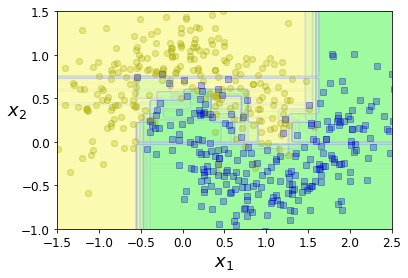

In [31]:
plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X[indices_with_replacement], y[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.02, contour=False)

plt.show()

De la même manière, si on entraîne un classificateur RF sur le dataset MNIST et qu'on trace l'importance de chaque pixel, on obtient l'image suivante :

In [32]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

In [36]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(random_state=42)

In [37]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

Saving figure mnist_feature_importance_plot


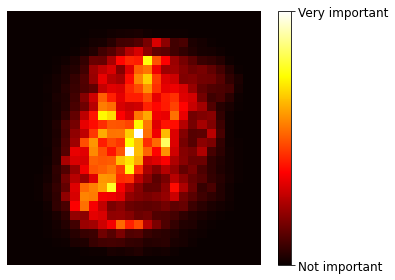

In [38]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

save_fig("mnist_feature_importance_plot")
plt.show()

## Boosting